# Soft Actor Critic implementation in JAX with function-based architecture

This architecture suits the speed ups that JAX offers better. That is, it makes the algorithm more efficient by enabling parallel and/or jitted computations.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

import equinox as eqx
import optax

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from environments.linear import Linear_SDI
from src.SAC_FP.utilities.replay_buffer import ReplayBuffer
from src.SAC_FP.network import LinearPolicyNetwork, QNetwork, ValueNetwork

from src.SAC_FP.init import *
from src.SAC_FP.train import *

plt.style.use('ggplot')


## Load data

In [2]:
key = jrandom.PRNGKey(0)
N = 10000
history_size = 1

env = Linear_SDI(end_time=20)
env.v = jnp.zeros(2)
env.boundary = True
env.min = jnp.array([-5, -5])
env.max = jnp.array([5, 5])
state_scale, control_scale, reward_scale = 5, 4, 25

def normalize(x, scale, inv=False):
    if inv:
        return x*scale
    else:
        return x/scale

buffer = ReplayBuffer(10000, 2, key, history_size=history_size)

obs_prev = env.reset()
for it in range(N):
    control = jrandom.normal(key, (1,))
    obs, rew, done, _ = env.step(control)
    buffer.feed(normalize(obs_prev, state_scale), normalize(control, control_scale), normalize(rew, reward_scale), normalize(obs, state_scale), done)

    # step
    key, subkey = jrandom.split(key)
    if done:
        obs_prev = env.reset()
    else:
        obs_prev = obs


## Initialize

In [3]:
"""Parameters"""
key = jrandom.PRNGKey(0)
gamma = .9
policy_update_freq = 2
batch_size = 128
control_scale = 1

lr = 2e-3
lr_v = lr
lr_q = lr
lr_pi = lr
lr_alpha = lr

"""Initialization"""
keys = jrandom.split(key, 4)
pi = pi_init(2, 1, lr_pi, keys[0], control_scale=control_scale)
vf = vf_init(2, 1, 32, 2, lr_v, keys[1])
vf_target = vf_init(2, 1, 32, 2, lr_v, keys[1])[0]
qf1 = qf_init(3, 1, 32, 2, lr_q, keys[2])
qf2 = qf_init(3, 1, 32, 2, lr_q, keys[3])
af = alpha_init(lr_alpha)

params = (pi, qf1, qf2, vf, vf_target, af)


## Train

In [4]:
"""Train"""
N = 8000
W = np.zeros((N, 2))
Ws = np.zeros((N, 2))
for step in range(N):
    params, loss = train_step(params, buffer, batch_size, step, key,
        gamma=gamma,
        policy_update_freq=policy_update_freq
    )
    pi_loss, q_loss, v_loss, alpha_loss = loss
    print(f'step={step:5.0f}\tpi={pi_loss:.5f}\tq={q_loss:.5f}\tv={v_loss:.5f}\talpha={alpha_loss:.5f}')

    # take step
    key, _ = jrandom.split(key)

    # save
    pi, qf1, qf2, vf, vf_target, af = params
    pi_fn, _, _ = pi
    W[step] = pi_fn.mu_layer.weight[0]

pi, qf1, qf2, vf, vf_target, af = params


step=    0	pi=6.80910	q=0.02558	v=48.40651	alpha=-5.66997
step=    1	pi=0.00000	q=0.01622	v=44.59554	alpha=-5.49653
step=    2	pi=6.64313	q=0.00905	v=45.99716	alpha=-5.59201
step=    3	pi=0.00000	q=0.00521	v=44.38643	alpha=-5.47870
step=    4	pi=6.63737	q=0.00274	v=46.33935	alpha=-5.66240
step=    5	pi=0.00000	q=0.00225	v=42.37194	alpha=-5.37219
step=    6	pi=5.95863	q=0.00192	v=36.75206	alpha=-5.03890
step=    7	pi=0.00000	q=0.00387	v=41.38855	alpha=-5.34358
step=    8	pi=6.25086	q=0.00356	v=40.83307	alpha=-5.34976
step=    9	pi=0.00000	q=0.00368	v=35.68422	alpha=-4.91813
step=   10	pi=5.91444	q=0.00357	v=36.57189	alpha=-5.06515
step=   11	pi=0.00000	q=0.00321	v=33.74984	alpha=-4.80285
step=   12	pi=5.87265	q=0.00339	v=37.01376	alpha=-5.07503
step=   13	pi=0.00000	q=0.00225	v=32.79301	alpha=-4.78049
step=   14	pi=5.43589	q=0.00153	v=31.28694	alpha=-4.71389
step=   15	pi=0.00000	q=0.00171	v=28.53859	alpha=-4.42838
step=   16	pi=4.93038	q=0.00106	v=27.13369	alpha=-4.28260
step=   17	pi=

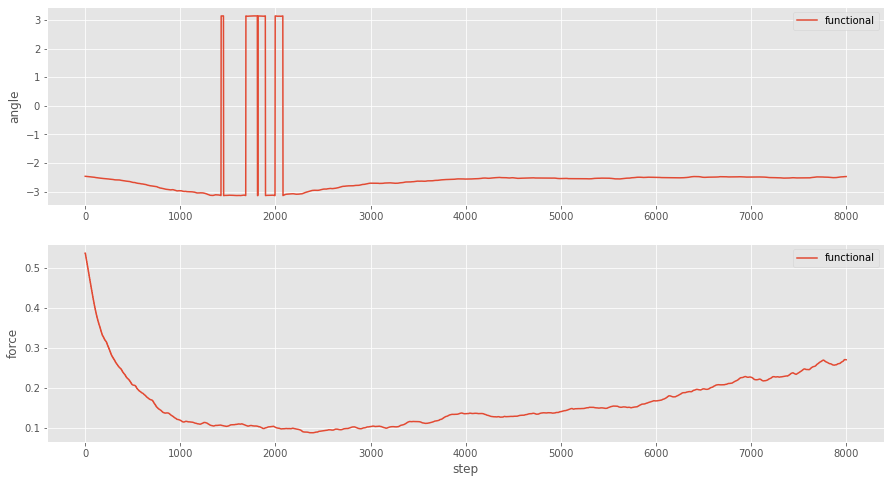

In [5]:
angle = jnp.arctan2(W[:,0], W[:,1])
norm = jnp.linalg.norm(W, axis=1)

fig, ax = plt.subplots(2, figsize=(15, 8))
ax[0].plot(angle, label='functional')
ax[1].plot(norm, label='functional')

ax[0].legend()
ax[1].legend()
ax[1].set_xlabel('step')
ax[0].set_ylabel('angle')
ax[1].set_ylabel('force')
plt.show()

In [6]:
# for step in range(10):
#     params, loss = train_step(params, batch_size, step, key)
#     pi_loss, q_loss, v_loss, alpha_loss = loss
#     print(f'step={step:5.0f}\tpi={pi_loss:.5f}\tq={q_loss:.5f}\tv={v_loss:.5f}\talpha={alpha_loss:.5f}')

#     # step
#     key, _ = jrandom.split(key)

## Test

### Network surface plots

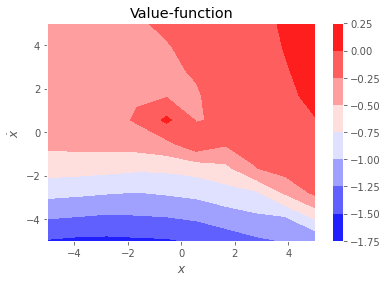

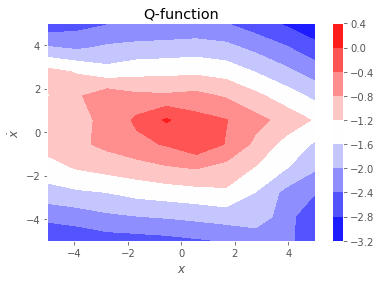

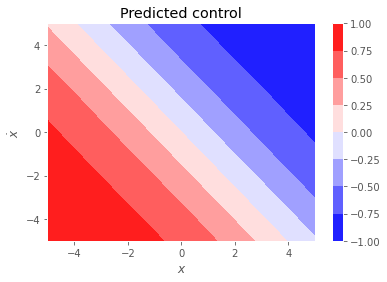

In [7]:
N = 10

x_space = np.linspace(-5, 5, N)
v_space = np.linspace(-5, 5, N)
#u_space = np.linspace(-control_scale, control_scale, N)

xv, vv = np.meshgrid(x_space, v_space)

V = np.zeros((N, N))
Q = np.zeros((N, N))
U = np.zeros((N, N))

v_fn, v_opt, v_state = vf
vt_fn = vf_target
q1_fn, q1_opt, q1_state = qf1
q2_fn, q2_opt, q2_state = qf2
pi_fn, pi_opt, pi_state = pi


for i, x in enumerate(x_space):
    for j, v in enumerate(v_space):
        state = jnp.array([x, v])
        control = 0
        V[i, j] = v_fn(state)
        q1 = q1_fn(state, control)
        q2 = q2_fn(state, control)
        Q[i, j] = jax.lax.min(q1, q2)
        U[i, j] = pi_fn.predict(state)


fig, ax = plt.subplots()
plt.contourf(xv, vv, V, cmap=cm.bwr)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')
plt.title('Value-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, Q, cmap=cm.bwr)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')
plt.title('Q-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, U, cmap=cm.bwr)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')
plt.title('Predicted control')
plt.show()


In [8]:
N = 10

x_space = np.linspace(-5, 5, N)
v_space = np.linspace(-5, 5, N)
u_space = np.linspace(-control_scale, control_scale, N)

xv, vv = np.meshgrid(x_space, v_space)

V = np.zeros((N, N))
Q = np.zeros((N, N, N))
U = np.zeros((N, N))

v_fn, v_opt, v_state = vf
vt_fn = vf_target
q1_fn, q1_opt, q1_state = qf1
q2_fn, q2_opt, q2_state = qf2
pi_fn, pi_opt, pi_state = pi


for i, x in enumerate(x_space):
    for j, v in enumerate(v_space):
        for k, u in enumerate(u_space):
            state = jnp.array([x, v])
            q1 = q1_fn(state, u)
            q2 = q2_fn(state, u)
            Q[i, j, k] = jax.lax.min(q1, q2)


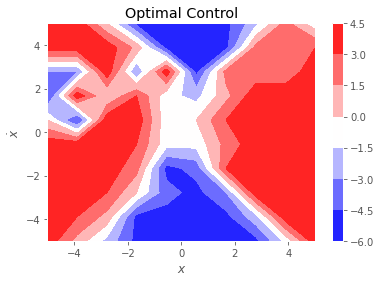

In [9]:
C = jnp.argmax(Q, axis=2) - 5

fig, ax = plt.subplots()
plt.contourf(xv, vv, C, cmap=cm.bwr)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')
plt.title('Optimal Control')
plt.show()


### Run test trial

In [10]:
def run(
    key,
    env,
    policy,
    T,
    x0 = None,
    n_obs = 2
):
    t_space = np.arange(0, T, env.dt)

    Y = np.zeros((len(t_space), n_obs))
    S = np.zeros((len(t_space), n_obs))

    y = env.reset(x0)
    for idx, t in enumerate(np.arange(0, T, env.dt)):
        u = policy.predict(y)
        y, rew, done, _ = env.step(u)
        Y[idx] = y
        S[idx] = env.state
    
    return S, Y


(-4.0, 4.0)

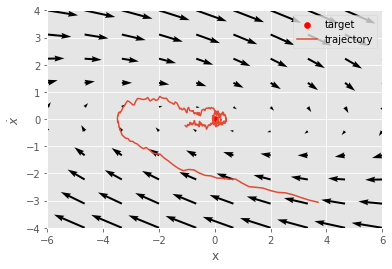

In [11]:
N = 10

x_space = np.linspace(-6, 6, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    control = pi_fn.predict(state)
    dx, dv = env.predict_deriv(state, control)
    qx[i,j] = dx
    qv[i,j] = dv

S, Y = run(key, env, pi_fn, 30, x0=jnp.array([4, -3]))

fig, ax = plt.subplots()
ax.scatter(0, 0, c='r', label='target')
ax.plot(S[:,0], S[:,1], label='trajectory')
ax.quiver(xv, vv, qx, qv)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel(r'$\dot{x}$')
ax.set_xlim([-6, 6])
ax.set_ylim([-4, 4])